In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix,f1_score,precision_score,recall_score,precision_recall_curve,accuracy_score,classification_report,plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_roc_curve,log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint, uniform
from warnings import filterwarnings
filterwarnings("ignore")

In [180]:
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense

In [3]:
import pickle
with open(r"Train_test_samples/train_test_split1_v4.1.pkl","rb") as a:
    train_test_split = pickle.load(a)
with open(r"saved_pickle/encoders_v4.1.pkl","rb") as a:
    encoders = pickle.load(a)
X_train = train_test_split['X_train']
X_val = train_test_split['X_val']
X_test = train_test_split['X_test']
y_train = train_test_split['y_train']
y_val = train_test_split['y_val']
y_test = train_test_split['y_test']


min_scaler = encoders['min_scaler']
std_scaler = encoders['std_scaler']
encoder = encoders['encoder']

In [4]:
display(X_train.shape, X_val.shape, X_test.shape)

(85092, 15)

(7289, 15)

(7465, 15)

In [5]:
display(y_train.shape, y_val.shape, y_test.shape)

(85092,)

(7289,)

(7465,)

In [6]:
numerical_cols = std_scaler.transform(X_train.select_dtypes(exclude='object'))
categorical_cols = encoder.transform(X_train.select_dtypes(include='object'))

X_train_scaled = np.hstack((numerical_cols,categorical_cols))

In [7]:
numerical_cols_ = std_scaler.transform(X_test.select_dtypes(exclude='object'))
categorical_cols_ = encoder.transform(X_test.select_dtypes(include='object'))

X_test_scaled = np.hstack((numerical_cols_,categorical_cols_))

In [8]:
numerical_cols__ = std_scaler.transform(X_val.select_dtypes(exclude='object'))
categorical_cols__ = encoder.transform(X_val.select_dtypes(include='object'))

X_val_scaled = np.hstack((numerical_cols__,categorical_cols__))

In [9]:
pd.DataFrame(y_train).value_counts()

team2_won_match
1                  46586
0                  38506
dtype: int64

In [10]:
def accuracy_func(x,y,over,model):
        x_ = x[x["current_over"]>=over]
        y_ = y[x["current_over"]>=over]
        
        numerical_cols = std_scaler.transform(x_.select_dtypes(exclude='object'))
        categorical_cols = encoder.transform(x_.select_dtypes(include='object'))

        x_ = np.hstack((numerical_cols,categorical_cols))
        return model.score(x_,y_)
        

In [11]:
def plot_scores(model,name):
    accuracy_list_train = []
    accuracy_list_test = []
    for i in range(20):

        accuracy_list_train.append(accuracy_func(X_train,y_train,i,model))
        accuracy_list_test.append(accuracy_func(X_test,y_test,i,model))

    import matplotlib.pyplot as plt
    plt.plot(range(1,21),accuracy_list_train)
    plt.plot(range(1,21),accuracy_list_test)
    plt.title(name)
    plt.xlabel('Over')
    plt.ylabel('Accuracy_score')
    plt.xticks(range(1,21))
    plt.grid()
    return plt.show()    

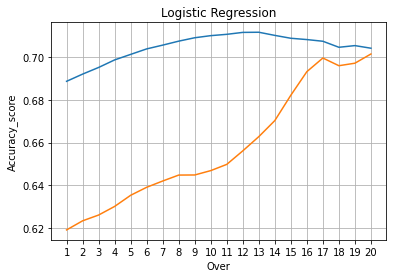

Training Accuracy: 0.6887486485216001
Test Accuracy: 0.6065303882562766
F1Score: 0.657183839349749


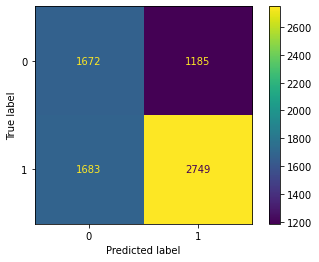

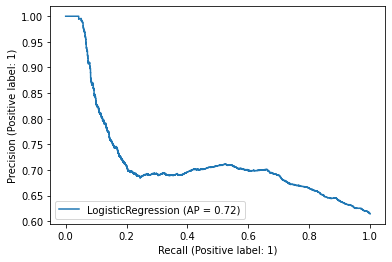

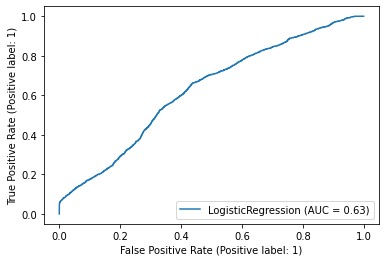

In [47]:
lr = LogisticRegression(penalty='l2',C = 0.008, solver='liblinear', class_weight={0:0.6,1:0.58})
lr.fit(X_train_scaled,y_train)
plot_scores(lr,'Logistic Regression')
print('Training Accuracy:',accuracy_score(y_train,lr.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_val,lr.predict(X_val_scaled)))
plot_confusion_matrix(lr,X_val_scaled,y_val)
plot_precision_recall_curve(lr,X_val_scaled,y_val)
plot_roc_curve(lr, X_val_scaled,y_val)
print('F1Score:', f1_score(y_val,lr.predict(X_val_scaled)))

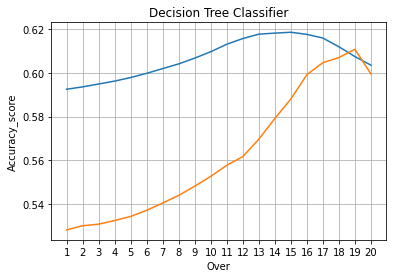

Training Accuracy: 0.5924881304940535
Test Accuracy: 0.6133900397859788
F1Score: 0.7432580174927113


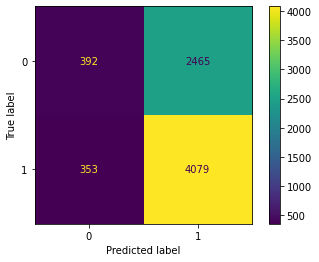

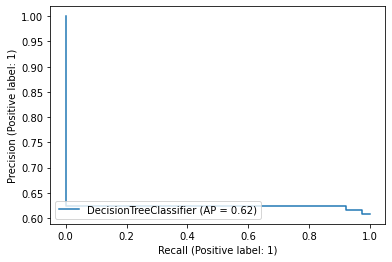

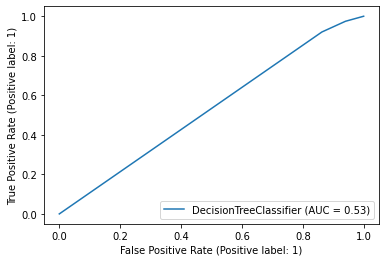

In [146]:
from sklearn.tree import DecisionTreeClassifier

#Hyper Parameter Tuning
param_dist = {  "splitter":['best','random'],
                "criterion":['gini','entropy'],
                "max_features":uniform(0.1,1.0),
                "max_depth":range(1,7),
                "max_leaf_nodes":range(1,7)
            }
clf = RandomizedSearchCV(DecisionTreeClassifier(class_weight={0:0.6,1:0.5}),
                        param_distributions= param_dist,n_iter=50, cv=5)
clf.fit(X_train_scaled,y_train)
dtc = clf.best_estimator_

dtc.fit(X_train_scaled,y_train)
# lr = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3, max_features=0.3).fit(X_train_scaled,y_train)
plot_scores(dtc,'Decision Tree Classifier')
print('Training Accuracy:',accuracy_score(y_train,dtc.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_val,dtc.predict(X_val_scaled)))
plot_confusion_matrix(dtc,X_val_scaled,y_val)
plot_precision_recall_curve(dtc,X_val_scaled,y_val)
plot_roc_curve(dtc, X_val_scaled,y_val)
print('F1Score:', f1_score(y_val,dtc.predict(X_val_scaled)))

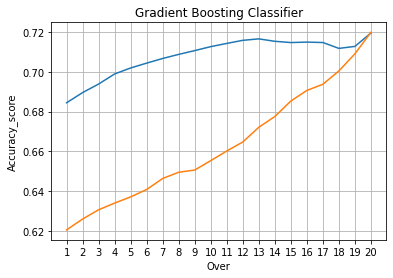

Training Accuracy: 0.6844239176420815
Test Accuracy: 0.6394567155988475
F1Score: 0.6961849710982659


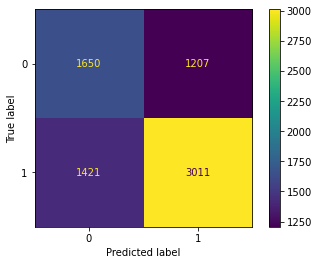

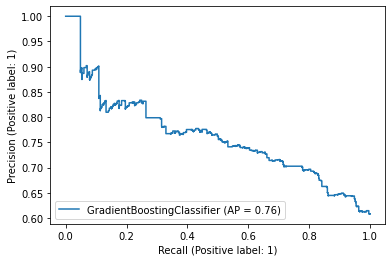

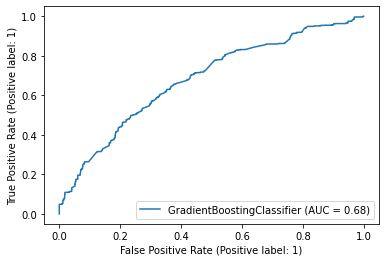

In [140]:
gbdt = GradientBoostingClassifier(
                            max_depth=3,
                            subsample=0.9,
                            max_features=0.5,
                            min_samples_leaf=3,
                            n_estimators = 30
                            )


gbdt.fit(X_train_scaled,y_train)

plot_scores(gbdt,'Gradient Boosting Classifier')
print('Training Accuracy:',accuracy_score(y_train,gbdt.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_val,gbdt.predict(X_val_scaled)))
plot_confusion_matrix(gbdt,X_val_scaled,y_val)
plot_precision_recall_curve(gbdt,X_val_scaled,y_val)
plot_roc_curve(gbdt, X_val_scaled,y_val)
print('F1Score:', f1_score(y_val,gbdt.predict(X_val_scaled)))

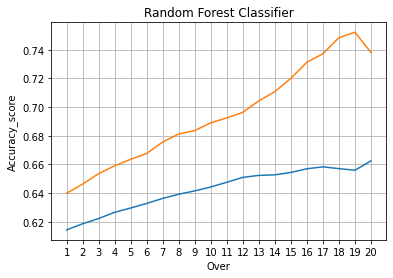

Training Accuracy: 0.6142763126968458
Test Accuracy: 0.5682535327205378
F1Score: 0.6438836709290484


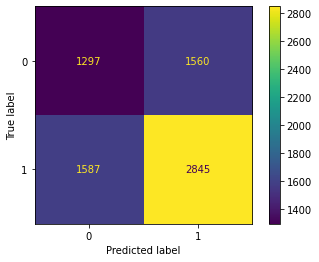

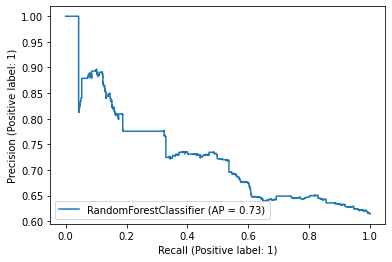

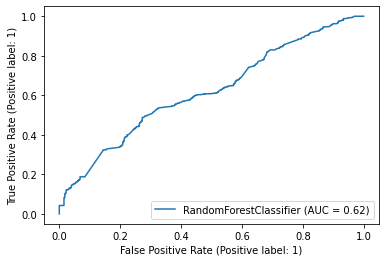

In [143]:
rfc = RandomForestClassifier(n_estimators= 200,
                             max_depth=3, 
                             max_leaf_nodes=3, 
                             max_features=0.3).fit(X_train_scaled,y_train)
plot_scores(rfc,'Random Forest Classifier')
print('Training Accuracy:',accuracy_score(y_train,rfc.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_val,rfc.predict(X_val_scaled)))
plot_confusion_matrix(rfc,X_val_scaled,y_val)
plot_precision_recall_curve(rfc,X_val_scaled,y_val)
plot_roc_curve(rfc, X_val_scaled,y_val)
print('F1Score:', f1_score(y_val,rfc.predict(X_val_scaled)))

In [76]:
import pickle
with open("saved_pickle/model_gbdt2_tb_inn1.pkl", 'wb') as f:
    pickle.dump(gbdt,f)

In [ ]:
with open("saved_pickle/model_gbdt_tb1_inn1.pkl", 'rb') as f:
    gbdt= pickle.load(f)

In [11]:
lr = GradientBoostingClassifier(max_depth=2,
                           max_features=0.6,
                           subsample=0.3,
                           n_estimators = 150)
lr.fit(X_train_scaled,y_train)

GradientBoostingClassifier(max_depth=2, max_features=0.6, n_estimators=150,
                           subsample=0.3)

In [12]:
# lr = XGBClassifier(max_depth=4,
#                 colsample_bytree=0.4,
#                 subsample=0.6,
#                 n_estimators = 100,
#                    reg_lambda = 30
#               )
# lr.fit(X_train_scaled,y_train)

In [185]:
# model = Sequential()

# model.add(Dense(units = 16, input_dim = 72, activation = 'relu'))
# model.add(Dense(units = 16, activation = 'relu'))
# # model.add(Dense(units = 16, activation = 'relu'))
# model.add(Dense(units = 1, activation = 'sigmoid'))

In [186]:
# model.compile(loss="binary_crossentropy", optimizer= "adam", metrics= ['accuracy'])

In [187]:
# model_fit = model.fit(x = X_train_scaled,y = y_train, batch_size=10, epochs=30, shuffle=True)

Epoch 1/30
9239/9239 [==============================] - 58s 6ms/step - loss: 0.4469 - accuracy: 0.7831
Epoch 2/30
9239/9239 [==============================] - 51s 6ms/step - loss: 0.2470 - accuracy: 0.8911
Epoch 3/30
9239/9239 [==============================] - 51s 6ms/step - loss: 0.1931 - accuracy: 0.9167
Epoch 4/30
9239/9239 [==============================] - 51s 6ms/step - loss: 0.1692 - accuracy: 0.9275
Epoch 5/30
9239/9239 [==============================] - 51s 6ms/step - loss: 0.1532 - accuracy: 0.9352
Epoch 6/30
9239/9239 [==============================] - 51s 6ms/step - loss: 0.1438 - accuracy: 0.9394
Epoch 7/30
9239/9239 [==============================] - 52s 6ms/step - loss: 0.1364 - accuracy: 0.9436
Epoch 8/30
9239/9239 [==============================] - 53s 6ms/step - loss: 0.1281 - accuracy: 0.9464
Epoch 9/30
9239/9239 [==============================] - 52s 6ms/step - loss: 0.1233 - accuracy: 0.9492
Epoch 10/30
9239/9239 [==============================] - 52s 6ms/step - l

In [188]:
lr = model_fit

In [433]:
# import pickle
# with open("saved_pickle/model_inn1.pkl", 'wb') as f:
#     pickle.dump(lr,f)

In [36]:
# with open("saved_pickle/column_sequence1.pkl", "rb") as a:
#     col_seq = pickle.load(a)

In [37]:
col_seq

Index(['score', 'team1_ban', 'team1_csk', 'team2_dd', 'team2_rr'], dtype='object')

# *Hyperparameter Tuning for LogisticRegression*

In [65]:
# param_dist = {
#              "C":[0.1,1,10,100],
#              "class_weight":{0:uniform(0,1), 1:uniform(0,1)}
#              }
# clf = RandomizedSearchCV(LogisticRegression(),
#                         param_distributions= param_dist, n_iter=10, cv=5)
# clf.fit(X_train_scaled,y_train)
# lr = clf.best_estimator_
# lr

LogisticRegression(C=0.1,
                   class_weight=<scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CAEA0A9CA0>)

# *Hyperparameter Tuning for RandomForest*

In [13]:
# param_dist = {"n_estimators": list(range(10,100,10)),
#                "max_features":range(5,20,2),
#                "max_samples":uniform(0.1,0.8),
#               "max_depth":range(3,15),
              
#              }
# clf = RandomizedSearchCV(RandomForestClassifier(),
#                         param_distributions= param_dist, n_iter=20, cv=5)
# clf.fit(X_train_scaled,y_train)
# lr = clf.best_estimator_
# lr

RandomForestClassifier(max_depth=14, max_features=9,
                       max_samples=0.7781461979598258, n_estimators=70)

In [255]:
# param_dist = {
#                 "n_estimators": range(10,40,10),
#                 "max_features":uniform(0.2,0.5),
#                 "max_depth":range(1,5),
#                 "min_samples_leaf":range(1,5)
#              }
# clf = RandomizedSearchCV(GradientBoostingClassifier(),
#                         param_distributions= param_dist,n_iter=30, cv=3)
# clf.fit(X_train_scaled,y_train)
# lr = clf.best_estimator_
# lr

GradientBoostingClassifier(max_features=0.4046128221252464, min_samples_leaf=3,
                           n_estimators=20)

## Checking what is causing the Underfitting in model

In [ ]:
import os
os.chdir('../')
# cwd = os.getcwd()  # Get the current working directory (cwd)
# files = os.listdir(cwd)  # Get all the files in that directory
# print("Files in %r: %s" % (cwd, files))

In [ ]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\Deepesh\\Practice\\archive (1)': ['.ipynb_checkpoints', '1648479876203.jpg', 'beautifulSoup.ipynb', 'best_model_yet.sav', 'best_rf_model.sav', 'bootstraping.ipynb', 'Data Preparation.ipynb', 'dataset_v1.csv', 'dataset_v2.csv', 'data_preparation.ipynb', 'data_preparationv2.ipynb', 'data_prep_v3.ipynb', 'data_v2.csv', 'data_v2.ipynb', 'data_v3.csv', 'functional.py', 'hyper_param_tuning.ipynb', 'idea.ipynb', 'IPL Ball-by-Ball 2008-2020.csv', 'IPL Matches 2008-2020.csv', 'Model Building', 'modelling.ipynb', 'Modelling1.ipynb', 'Modelling2-2.ipynb', 'Modelling2.ipynb', 'Modelling3.ipynb', 'Modelling4.ipynb', 'saved_pickle', 'special_split.ipynb', 'Test_x.pkl', 'titanic', 'titanic.ipynb', 'titanic.zip', 'Train_test_samples', 'Untitled Folder', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb']


In [ ]:
view = pd.read_csv('abc.csv')

In [ ]:
view

,Unnamed: 0,0,1
0,team1=>Gujarat Titans,121.0,1233.0
1,team1=>Kochi Tuskers Kerala,123.0,382.0
2,venue=>OUTsurance Oval,124.0,NaN
3,venue=>Vidarbha Cricket Association Stadium,124.0,NaN
4,venue=>Holkar Cricket Stadium,125.0,834.0
5,venue=>Himachal Pradesh Cricket Association St...,127.0,492.0
6,venue=>JSCA International Stadium Complex,224.0,365.0
7,team1=>Rising Pune Supergiant,246.0,374.0
8,venue=>St George's Park,248.0,247.0
9,venue=>Buffalo Park,250.0,130.0


In [173]:
y_train[X_train[X_train["venue"]=='OUTsurance Oval'].index]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
data = pd.read_csv('data_v3.csv')

In [169]:
X_train = X_train.reset_index()

In [164]:
X_train.shape

(74959, 15)

In [170]:
view = pd.DataFrame({'venue':X_train.venue.unique()})

In [171]:
view['lose'] = view['venue'].map(lambda x:(y_train[X_train[X_train['venue']==x].index]==0).astype(int).sum())
view['win'] = view['venue'].map(lambda x:(y_train[X_train[X_train['venue']==x].index]==1).astype(int).sum())

In [172]:
view

,venue,lose,win
0,M Chinnaswamy Stadium,3004,4161
1,Punjab Cricket Association IS Bindra Stadium,2296,2810
2,Feroz Shah Kotla,3346,3768
3,Eden Gardens,2737,4236
4,Sawai Mansingh Stadium,1245,2607
5,Rajiv Gandhi International Stadium,2742,2972
6,"MA Chidambaram Stadium, Chepauk",2978,1754
7,Dr DY Patil Sports Academy,627,1085
8,Wankhede Stadium,3234,3566
9,Newlands,243,119


In [134]:
data[data['venue']=='Green Park'].id.unique()

array([ 981001,  981007, 1082640, 1082643], dtype=int64)